# Predicción de siniestralidad usando redes neuronales

## instalacion de librerias

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

## Carga de la base de datos y analisis exploratorio inicial

Informacion del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   zona         412 non-null    int64  
 1   clase veh    412 non-null    int64  
 2   Edad veh     412 non-null    int64  
 3   Bonus        412 non-null    int64  
 4   duracion     412 non-null    float64
 5   nsin         412 non-null    int64  
 6   costesin     412 non-null    int64  
 7   num.pólizas  412 non-null    int64  
 8   freq.sin     406 non-null    float64
 9   severidad    181 non-null    float64
dtypes: float64(3), int64(7)
memory usage: 32.3 KB
None

 Vista inicial:
   zona  clase veh  Edad veh  Bonus   duracion  nsin  costesin  num.pólizas  \
0     1          1         1      1  12.416438     2     14533           25   
1     1          1         1      2   3.260274     0         0            8   
2     1          1         1      3  11.569866     1    

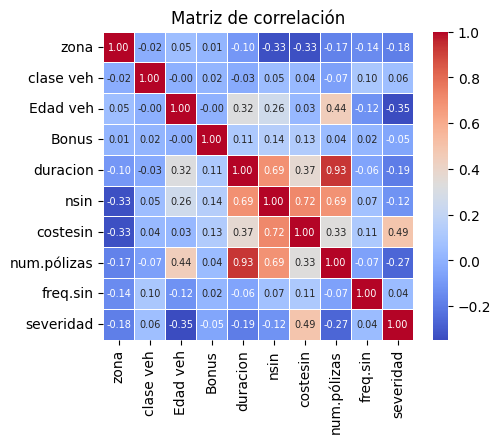

In [13]:
# Read the Excel file
file_path = "/Users/javiergarcia/MANADINE/3 SEMESTER/ACTUARIAL/Tarea RD/tablaOlhsson.xlsx"
df = pd.read_excel(file_path)

# Display basic information about the dataset
print("Informacion del dataset:")
print(df.info())

# Display the first few rows of the dataset
print("\n Vista inicial:")
print(df.head())

# Descriptive statistics
print("\n Analisis descriptivo:")
print(df.describe())

# Correlation matrix
correlation_matrix = df.corr()
print("\n matriz de correlación:")
print(correlation_matrix)

# Heatmap for visualizing the correlation matrix
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", 
            fmt=".2f", linewidths=.5, annot_kws={"size": 7})
plt.title("Matriz de correlación")

# Show the plots
plt.show()


## Limpieza de la base de datos
Se realizara la siguiente tranformacion en los datos:
- En las variables _severidad_ y _freq.sin_ se encuentran valores nulos, se reemplazaran por 0.
- Generacion de variables dummies para las variables _'zona'_, _'clase_veh'_ y _'Bonus'_.

In [14]:
# replace severidad and freq null with 0
df.fillna({'severidad': 0,'freq.sin': 0}, inplace=True)

# Create dummy variables
df = pd.get_dummies(df, columns=['zona', 'clase veh', 'Bonus'])

# Print info
print("Informacion del dataset:")
print(df.info())

# Descriptive statistics
print("\nVerificacion de limpieza:")
print(df.describe())


Informacion del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Edad veh     412 non-null    int64  
 1   duracion     412 non-null    float64
 2   nsin         412 non-null    int64  
 3   costesin     412 non-null    int64  
 4   num.pólizas  412 non-null    int64  
 5   freq.sin     412 non-null    float64
 6   severidad    412 non-null    float64
 7   zona_1       412 non-null    bool   
 8   zona_2       412 non-null    bool   
 9   zona_3       412 non-null    bool   
 10  zona_4       412 non-null    bool   
 11  zona_5       412 non-null    bool   
 12  zona_6       412 non-null    bool   
 13  zona_7       412 non-null    bool   
 14  clase veh_1  412 non-null    bool   
 15  clase veh_2  412 non-null    bool   
 16  clase veh_3  412 non-null    bool   
 17  clase veh_4  412 non-null    bool   
 18  clase veh_5  412 non-null

## Red neuronal

### Modelo de siniestralidad

Para el modelo de predicción, se divide el conjunto de datos en prueba y entrenamiento en una proporción del 80% para entrenamiento y del 20% para prueba. Las bases de datos de entrenamiento se preprocesarán con un escalado siguiendo la siguiente fórmula:

$$z = \frac{x - \text{media}}{\text{Desviación estándar}} $$

El modelo se realizará mediante el uso de la librería de Keras.

#### Parámetros del modelo

Se realizará una red de 3 capas descritas de la siguiente manera:

1. 64 neuronas con una función de activación entre cada neurona, utilizando la siguiente función de activación que determina la salida de cada neurona (permitiendo el aprendizaje en el modelo para "aprender" patrones en el modelo introduciendo no linealidad), siguiendo la siguiente fórmula:

\begin{align}
f(x) = \max(0, x)
\end{align}

2. 32 neuronas con la misma función de activación de la primera capa.

3. 1 neurona sin función de activación, dejando "linealidad" en esta capa.

#### Ejecución del modelo

Para la ejecución del modelo, se especifica un parámetro de optimización en el entrenamiento llamado "Adam". Este parámetro permite al modelo optimizar el aprendizaje del modelo mediante el histórico de las gradientes, es un parámetro ampliamente usado en modelos de deep learning. Igualmente, se especifica el parámetro de corrección que se minimizará en cada iteración de ejecución del modelo como MSE (Mean Square Error), que se define de la siguiente manera:

\begin{align}
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\end{align}


Finalmente, se especifica el número de veces que el modelo iterará el conjunto de datos de entrenamiento, que en este caso serán 200 veces. Se detalla también el tamaño de muestras con las que cada iteración entrenará (32 muestras).

#### Evaluacion del modelo
Para la valoracion del performance del modelo se usara el _RMSE_ que muestra el la magnitud promedio de los valores estimados y los reales. la estimacion del _RMSE_ sigue la siguiente formula:

\begin{align}
RMSE = \sqrt{\frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{n}}
\end{align}


In [17]:
# Separate features and target variable
X = df.drop('severidad', axis=1)
y = df['severidad']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', 
                input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, 
        validation_split=0.2, verbose=0)

# Evaluate the model on the test set
y_pred = model.predict(X_test_scaled)

# Calculate the error or any other performance metric you are interested in
error = np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))

print(f'Root Mean Squared Error (RMSE): {error}')

3/3 [==============================] - 0s 854us/step
Root Mean Squared Error (RMSE): 25129.1811745896


### Resultados del modelo de prediccion de siniestralidad
El modelo establece un valor de 25129 euros como error.

### Modelo de numero de frecuencias
Para el calculo de este modelo se dejaran los mismos parametros que el modelo de siniestralidad.

In [18]:
# Separate features and target variable
X = df.drop('freq.sin', axis=1)
y = df['freq.sin']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, 
        validation_split=0.2, verbose=0)

# Evaluate the model on the test set
y_pred = model.predict(X_test_scaled)

# Calculate the error or any other performance metric you are interested in
error = np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))

print(f'Root Mean Squared Error (RMSE): {error}')

3/3 [==============================] - 0s 1ms/step
Root Mean Squared Error (RMSE): 0.09922060262480642


### Resultados del modelo de prediccion de siniestralidad
El modelo establece un valor de 0.09 siniestros como error.